In [1]:
cd /home/ec2-user/SageMaker/plasticClassification1

/home/ec2-user/SageMaker/plasticClassification1


In [2]:
import boto3
import sagemaker

print(sagemaker.__version__)

sess = sagemaker.Session()
bucket = sess.default_bucket()

2.119.0


In [3]:
train_dir = 'RecordIo_lst_file'
test_dir = 'Io_test_lst_file'
# val_dir = 'val'
train_dir

'RecordIo_lst_file'

In [4]:
prefix = 'plastic-classification'
training_input_path   = sess.upload_data(train_dir, key_prefix=prefix+'/training')
validation_input_path = sess.upload_data(test_dir, key_prefix=prefix+'/validation')
s3_output = 's3://{}/{}/output/'.format(bucket, prefix)

## Get the name of the image classification algorithm in our region

In [5]:

from sagemaker import image_uris

region = boto3.Session().region_name    
container = image_uris.retrieve('image-classification', region)
print(container)


811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1


## Configure the training job

In [6]:
role = sagemaker.get_execution_role()

ic = sagemaker.estimator.Estimator(container,
                                   role, 
                                   instance_count=1, 
                                   instance_type='ml.p3.2xlarge',
                                   output_path=s3_output)


## Set algorithm parameters

In [7]:
ic.set_hyperparameters(num_layers=18,               # Train a Resnet-18 model
                       use_pretrained_model=0,      # Train from scratch
                       num_classes=3,               # PET, HDEP and OTHERS                        
                       mini_batch_size=128,
                       num_training_samples=6000,  # Number of training samples
                       image_shape = '3,220,220',
                       epochs=10)                   # Learn the training samples 10 times
# 

## Set dataset parameters

In [8]:
train_data = sagemaker.TrainingInput(training_input_path, 
                                        distribution='FullyReplicated', 
                                        content_type='application/x-recordio',
                                        s3_data_type='S3Prefix')

validation_data = sagemaker.TrainingInput(validation_input_path,
                                             distribution='FullyReplicated', 
                                             content_type='application/x-recordio', 
                                             s3_data_type='S3Prefix')

s3_channels = {'train': train_data, 'validation': validation_data}

## Train the model

In [9]:
ic.fit(inputs=s3_channels)

2022-12-16 11:38:09 Starting - Starting the training job...
2022-12-16 11:38:35 Starting - Preparing the instances for trainingProfilerReport-1671190688: InProgress
............
2022-12-16 11:40:23 Downloading - Downloading input data...
2022-12-16 11:41:03 Training - Downloading the training image............
2022-12-16 11:43:08 Training - Training image download completed. Training in progress....Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Fri Dec 16 11:43:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | G

## Deploy the model

In [10]:
ic_predictor = ic.deploy(initial_instance_count=1,
                         instance_type='ml.t2.medium')    # $0.05 per hours 

-------------------!

## Download a test image

--2022-12-16 13:00:29--  https://m.media-amazon.com/images/I/61y4HOllrdL._SX342_.jpg
Resolving m.media-amazon.com (m.media-amazon.com)... 18.165.82.237, 2600:9000:24f4:5400:1d:d7f6:39d2:2dc1, 2600:9000:24f4:de00:1d:d7f6:39d2:2dc1, ...
Connecting to m.media-amazon.com (m.media-amazon.com)|18.165.82.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8401 (8.2K) [image/jpeg]
Saving to: ‘/tmp/test.jpg’

100%[======================================>] 8,401       --.-K/s   in 0s      

2022-12-16 13:00:29 (221 MB/s) - ‘/tmp/test.jpg’ saved [8401/8401]



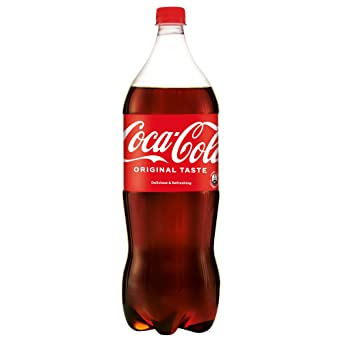

In [23]:
# Dog
!wget -O /tmp/test.jpg https://m.media-amazon.com/images/I/61y4HOllrdL._SX342_.jpg
file_name = '/tmp/test.jpg'
from IPython.display import Image
Image(file_name)

Hello, World! 


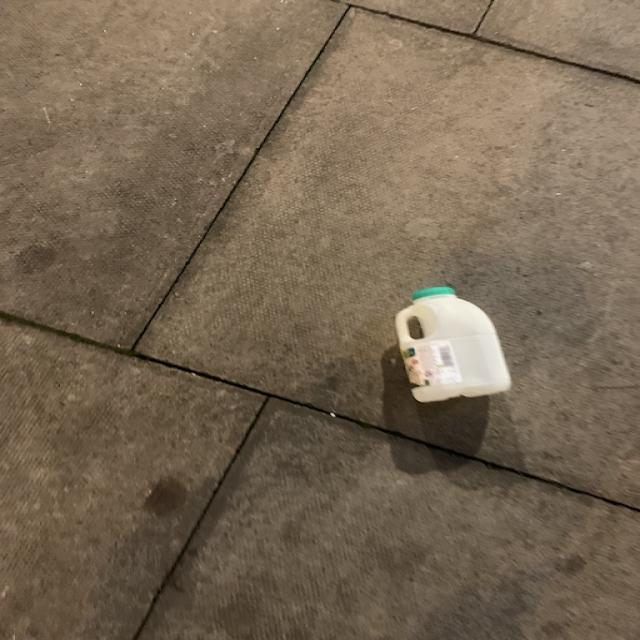

In [24]:
import subprocess

def runcmd(cmd, verbose = False, *args, **kwargs):

    process = subprocess.Popen(
        cmd,
        stdout = subprocess.PIPE,
        stderr = subprocess.PIPE,
        text = True,
        shell = True
    )
    std_out, std_err = process.communicate()
    if verbose:
        print(std_out.strip(), std_err)
    pass

runcmd('echo "Hello, World!"', verbose = True)
runcmd('!wget -O /tmp/test.jpg https://m.media-amazon.com/images/I/61y4HOllrdL._SX342_.jpg')
file_name1 = 'test/2-HDPE/HDPEM195_jpg.rf.fd21430e138036393e9a9c90e0f4bdf2.jpg'
Image(file_name1)

## Predict test image

In [25]:
import boto3, json
import numpy as np

runtime = boto3.Session().client(service_name='runtime.sagemaker')

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)

response = runtime.invoke_endpoint(EndpointName=ic_predictor.endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)

result = response['Body'].read()
result = json.loads(result)
index = np.argmax(result)
print(result[index], index)

# 1-PET 0       2-HDPE 1         others 2

if index == 0:
    print('PET')
elif index == 1:
    print('HDPE')
else:
    print('others')


0.7520400285720825 0
PET


## Delete endpoint

In [ ]:
ic_predictor.delete_endpoint()